In [2]:
# Mount Drive
from google.colab import drive

drive.mount('content/')

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


os.chdir('content/My Drive/rock-paper-scissors')

In [ ]:
from torchvision import transforms

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

traindir = 'my-data/train'
valdir = 'my-data/val' 

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val'])
}

BATCH_SIZE = 4

dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [ ]:
from torchvision import models

def get_pretrained_model(model_name, parallel=True):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """
    # if the model is 'vgg16':
    # freeze all layers
    # assign the no of input features to variable n_inputs
    # reset the last layer of the model a nn.Sequential layer
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 4), nn.LogSoftmax(dim=1))
    
    # if the model is 'resnet50':
    # freeze all layers
    # assign the no. of input features of the last layer to the variable n_inputs
    # reset the last layer so that we can train it on our dataset
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 4), nn.LogSoftmax(dim=1))
    
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
          param.requires_grad = False
        
        n_inputs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 4), nn.LogSoftmax(dim=1))
    
    elif model_name == 'densenet161':
        model = models.densenet161(pretrained=True)
        for param in model.parameters():
          param.requires_grad = False
        
        n_inputs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 4), nn.LogSoftmax(dim=1))
    
    elif model_name == 'wide_resnet101_2':
        model = models.wide_resnet101_2(pretrained=True)
        for param in model.parameters():
          param.requires_grad = False
        
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
              nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
              nn.Linear(256, 4), nn.LogSoftmax(dim=1))
    elif model_name == "googlenet":
        model = models.googlenet(pretrained=True)
        for param in model.parameters():
          param.requires_grad = False
        
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
              nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
              nn.Linear(256, 4), nn.LogSoftmax(dim=1))
      
    # Move to gpu and parallelize
    model = model.to(device)
    if parallel:
        model = nn.DataParallel(model)

    return model

In [ ]:
available_models = [
    "vgg16",
    "resnet50",
    "wide_resnet101_2",
    "densenet161",
    "mobilenet_v2"
]

In [ ]:

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')


    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        # Training loop
        for idx, (images, labels) in enumerate(train_loader):
            # Tensors to gpu
            images, labels = images.cuda(), labels.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(images)

            # Loss and backpropagation of gradients
            loss = criterion(output, labels)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * images.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * images.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (idx + 1) / len(train_loader):.2f}% complete.', end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for images, labels in valid_loader:
                    # Tensors to gpu
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    output = model(images)

                    # Validation loss
                    loss = criterion(output, labels)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * images.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(labels.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * images.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                    best_model = model

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if int(epochs_no_improve) >= int(max_epochs_stop):
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )


                        # Attach the optimizer
                        model.optimizer = optimizer

                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )

    return model, history

## Experiment 1
Trying a pretrained vgg16 model with the available 900 or so images 

In [ ]:
model = get_pretrained_model('vgg16', parallel=True)

In [ ]:
import torch.optim as optim

criterion =nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.6772 	Validation Loss: 1.0379
		Training Accuracy: 73.34%	 Validation Accuracy: 70.97%

Epoch: 1 	Training Loss: 0.4540 	Validation Loss: 1.0255
		Training Accuracy: 82.26%	 Validation Accuracy: 72.18%

Epoch: 2 	Training Loss: 0.4237 	Validation Loss: 1.0063
		Training Accuracy: 84.77%	 Validation Accuracy: 72.98%

Epoch: 3 	Training Loss: 0.3878 	Validation Loss: 1.2838
		Training Accuracy: 85.31%	 Validation Accuracy: 68.55%

Epoch: 4 	Training Loss: 0.3599 	Validation Loss: 1.4249
		Training Accuracy: 87.81%	 Validation Accuracy: 72.98%

Epoch: 5 	Training Loss: 0.2928 	Validation Loss: 1.4175
		Training Accuracy: 89.99%	 Validation Accuracy: 70.97%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.01 and acc: 70.97%


In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])

Model has been trained for: 12 epochs.


Epoch: 0 	Training Loss: 0.3021 	Validation Loss: 1.3720
		Training Accuracy: 88.57%	 Validation Accuracy: 73.39%

Epoch: 1 	Training Loss: 0.2492 	Validation Loss: 1.5592
		Training Accuracy: 91.40%	 Validation Accuracy: 74.60%

Epoch: 2 	Training Loss: 0.2494 	Validation Loss: 1.2533
		Training Accuracy: 91.08%	 Validation Accuracy: 76.21%

Epoch: 3 	Training Loss: 0.2367 	Validation Loss: 1.1416
		Training Accuracy: 91.08%	 Validation Accuracy: 77.82%

Epoch: 4 	Training Loss: 0.2582 	Validation Loss: 1.4639
		Training Accuracy: 90.42%	 Validation Accuracy: 75.81%

Epoch: 5 	Training Loss: 0.2236 	Validation Loss: 1.2126
		Training Accuracy: 90.75%	 Validation Accuracy: 79.44%

Epoch: 6 	Training Loss: 0.2257 	Validation Loss: 1.3812
		Training Accuracy: 91.51%	 Validation Accuracy: 77.42%

Early Stopping! Total epochs: 6. Best epoch: 3 with loss: 1.14 and acc: 77.42%
Model has been trained for: 19 epochs.


Epoch: 0 	Training Loss: 0.2665 	V

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

def display_grid(rows, cols, images, path=False, labels = [], preds=[], figsize=(20, 6)):
    """
    Displays images in a grid, given the image paths
    Parameters:
        *img_names: A sequence of absolute image paths
        rows: no. of rows in the grid
        cols: no. of cols in the grid
    Returns:
        displays the given images in a grid
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    row, col = 0, 0
    
    if path:
        idx = 0
        for path in images:
            # Converting image to numpy array
            img_file = open(path, 'rb')
            img_array = plt.imread(img_file)

            # Axis properties
            axes[row, col].imshow(img_array)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            if preds!=[]:
                axes[row, col].set_title(f"Prediction: {preds[idx]}, Target: {labels[idx]}", color='white', fontsize=20)

            # Updating the grid coordinates row and col
            if col==cols-1:
                row+=1
                col=0
            elif row==rows-1:
                col+=1
            else:
                col+=1
            idx += 1
    else:
        row, col = 0, 0
        for i in range(images.shape[0]):
            # Axis properties
                axes[row, col].imshow(images[i, :, :, :])
                axes[row, col].set_xticks([])
                axes[row, col].set_yticks([])
                if labels != []:
                    title_num = int(labels[i])
                    if title_num==0:
                        title = 'ROCK'
                    elif title_num==1:
                        title = 'PAPER'
                    elif title_num==2:
                        title = 'SCISSORS'
                    axes[row, col].set_title(f'{i}=>{title}', color='red', fontsize=13)

                # Updating the grid coordinates row and col
                if col==cols-1:
                    row+=1
                    col=0
                elif row==rows-1:
                    col+=1
                else:
                    col+=1

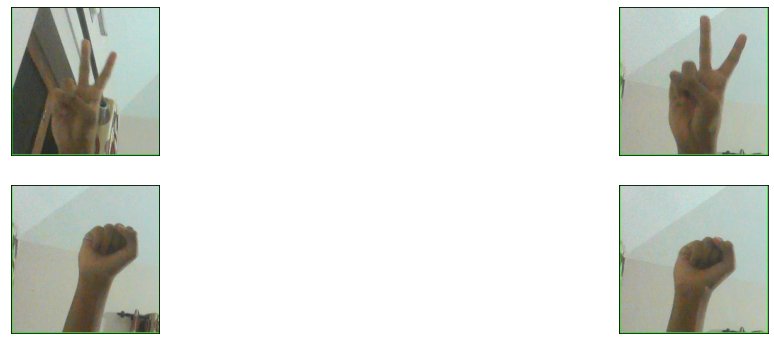

In [ ]:
images = ['my-data/val/c2/scissors-1.jpg', 'my-data/val/c2/scissors-5.jpg', 'my-data/val/c0/rock-3.jpg', 'my-data/val/c0/rock-4.jpg']
labels = [2, 2, 0, 0]
display_grid(2, 2, images=images, path=True, labels=labels)

In [ ]:
torch.save(model, 'vgg16-model-1.pt')

In [ ]:
image = Image.open(images[0])
image = image_transforms['val'](image).view(1, 3, 224, 224)
torch.argmax(model(image))

tensor(2, device='cuda:0')

## Experiment 2 
trying a vgg-16 model but without dataparallel

In [ ]:
model = get_pretrained_model('vgg16', parallel=False)

In [ ]:
import torch.optim as optim

criterion =nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.7411 	Validation Loss: 0.8891
		Training Accuracy: 70.62%	 Validation Accuracy: 68.55%

Epoch: 1 	Training Loss: 0.4262 	Validation Loss: 0.9831
		Training Accuracy: 83.24%	 Validation Accuracy: 74.19%

Epoch: 2 	Training Loss: 0.3818 	Validation Loss: 0.9011
		Training Accuracy: 86.29%	 Validation Accuracy: 73.79%

Epoch: 3 	Training Loss: 0.3018 	Validation Loss: 1.0279
		Training Accuracy: 89.66%	 Validation Accuracy: 74.60%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.89 and acc: 74.60%
Model has been trained for: 4 epochs.


Epoch: 0 	Training Loss: 0.3301 	Validation Loss: 1.2469
		Training Accuracy: 87.60%	 Validation Accuracy: 73.79%

Epoch: 1 	Training Loss: 0.3293 	Validation Loss: 1.0104
		Training Accuracy: 88.57%	 Validation Accuracy: 73.79%

Epoch: 2 	Training Loss: 0.3008 	Validation Loss: 1.2789
		Training Accuracy: 89.88%	 Validation Accuracy: 73.39%

Epoch: 3 	Training Loss: 0.2748 	Validatio

In [ ]:
torch.save(model, 'vgg16-model-2.pt')

## Experiment 3
Training a pretrained resnet50 model on my images as well as the already available downloaded data

In [ ]:
np.random.seed(42)

traindir = 'datasets/final/D1'
valdir = 'datasets/final/validation'

old_data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val'])
}

BATCH_SIZE = 4

old_dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
np.random.seed(42)

from torch.utils.data import ConcatDataset

full_data = {
    "train": ConcatDataset((data['train'], old_data['train'])),
    "val": ConcatDataset((data['val'], old_data['val']))
}

full_dataloaders = {
    'train': DataLoader(full_data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(full_data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
resnet50_on_full_data = get_pretrained_model('resnet50', parallel=False)

In [ ]:
criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_on_full_data.parameters(), lr=3e-4)

In [ ]:
resnet50_on_full_data, history = train(resnet50_on_full_data, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0154 	Validation Loss: 0.9196
		Training Accuracy: 54.09%	 Validation Accuracy: 69.50%

Epoch: 1 	Training Loss: 0.8190 	Validation Loss: 0.8633
		Training Accuracy: 66.10%	 Validation Accuracy: 71.55%

Epoch: 2 	Training Loss: 0.7334 	Validation Loss: 0.8679
		Training Accuracy: 69.56%	 Validation Accuracy: 74.19%

Epoch: 3 	Training Loss: 0.6854 	Validation Loss: 0.9208
		Training Accuracy: 71.35%	 Validation Accuracy: 72.73%

Epoch: 4 	Training Loss: 0.6953 	Validation Loss: 0.7663
		Training Accuracy: 70.73%	 Validation Accuracy: 78.89%

Epoch: 5 	Training Loss: 0.6704 	Validation Loss: 0.7908
		Training Accuracy: 72.83%	 Validation Accuracy: 77.42%

Epoch: 6 	Training Loss: 0.6612 	Validation Loss: 0.6858
		Training Accuracy: 73.48%	 Validation Accuracy: 79.77%

Epoch: 7 	Training Loss: 0.6227 	Validation Loss: 0.5871
		Training Accuracy: 75.55%	 Validation Accuracy: 82.99%

Epoch: 8 	Training Loss: 0.6174 	Validation Lo

In [ ]:
resnet50_on_full_data, history = train(resnet50_on_full_data, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])

Model has been trained for: 11 epochs.


Epoch: 0 	Training Loss: 0.6075 	Validation Loss: 1.0937
		Training Accuracy: 74.87%	 Validation Accuracy: 77.71%

Epoch: 1 	Training Loss: 0.5889 	Validation Loss: 1.0723
		Training Accuracy: 76.10%	 Validation Accuracy: 75.07%

Epoch: 2 	Training Loss: 0.6223 	Validation Loss: 0.9155
		Training Accuracy: 74.56%	 Validation Accuracy: 77.42%

Epoch: 3 	Training Loss: 0.5678 	Validation Loss: 1.1257
		Training Accuracy: 77.46%	 Validation Accuracy: 77.13%

Epoch: 4 	Training Loss: 0.5762 	Validation Loss: 0.8061
		Training Accuracy: 75.79%	 Validation Accuracy: 80.94%

Epoch: 5 	Training Loss: 0.5773 	Validation Loss: 0.8346
		Training Accuracy: 77.03%	 Validation Accuracy: 79.18%

Epoch: 6 	Training Loss: 0.5616 	Validation Loss: 1.0111
		Training Accuracy: 76.94%	 Validation Accuracy: 78.89%

Epoch: 7 	Training Loss: 0.5986 	Validation Loss: 1.1247
		Training Accuracy: 75.36%	 Validation Accuracy: 73.61%

Early Stopping! Total epochs: 7. Best e

In [ ]:
torch.save(resnet50_on_full_data, "models/resnet59_fulldata-1.pt")

In [ ]:
resnet50_on_full_data, history = train(resnet50_on_full_data, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])
torch.save(resnet50_on_full_data, "models/resnet59_fulldata-2.pt")
resnet50_on_full_data, history = train(resnet50_on_full_data, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])
torch.save(resnet50_on_full_data, "models/resnet59_fulldata-3.pt")


Model has been trained for: 19 epochs.


Epoch: 0 	Training Loss: 0.5586 	Validation Loss: 1.0171
		Training Accuracy: 77.25%	 Validation Accuracy: 77.13%

Epoch: 1 	Training Loss: 0.5679 	Validation Loss: 0.7402
		Training Accuracy: 76.51%	 Validation Accuracy: 79.77%

Epoch: 2 	Training Loss: 0.5601 	Validation Loss: 0.9589
		Training Accuracy: 77.25%	 Validation Accuracy: 78.01%

Epoch: 3 	Training Loss: 0.5289 	Validation Loss: 0.9549
		Training Accuracy: 78.11%	 Validation Accuracy: 79.47%

Epoch: 4 	Training Loss: 0.5402 	Validation Loss: 0.9806
		Training Accuracy: 78.26%	 Validation Accuracy: 78.30%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.74 and acc: 78.30%
Model has been trained for: 24 epochs.


Epoch: 0 	Training Loss: 0.5524 	Validation Loss: 1.0214
		Training Accuracy: 77.15%	 Validation Accuracy: 80.35%

Epoch: 1 	Training Loss: 0.5543 	Validation Loss: 0.6517
		Training Accuracy: 77.74%	 Validation Accuracy: 82.11%

Epoch: 2 	Training Loss: 0.5192 	V

In [ ]:
resnet50_on_full_data, history = train(resnet50_on_full_data, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])

Model has been trained for: 29 epochs.


Epoch: 0 	Training Loss: 0.5286 	Validation Loss: 1.2278
		Training Accuracy: 78.51%	 Validation Accuracy: 77.71%

Epoch: 1 	Training Loss: 0.5338 	Validation Loss: 0.8229
		Training Accuracy: 78.51%	 Validation Accuracy: 79.77%

Epoch: 2 	Training Loss: 0.5059 	Validation Loss: 0.8761
		Training Accuracy: 79.53%	 Validation Accuracy: 80.65%

Epoch: 3 	Training Loss: 0.5416 	Validation Loss: 1.0561
		Training Accuracy: 78.57%	 Validation Accuracy: 77.42%

Epoch: 4 	Training Loss: 0.5251 	Validation Loss: 0.8139
		Training Accuracy: 79.04%	 Validation Accuracy: 81.23%

Epoch: 5 	Training Loss: 0.4983 	Validation Loss: 0.9573
		Training Accuracy: 79.81%	 Validation Accuracy: 79.47%

Epoch: 6 	Training Loss: 0.5056 	Validation Loss: 1.0065
		Training Accuracy: 79.28%	 Validation Accuracy: 78.89%

Epoch: 7 	Training Loss: 0.4970 	Validation Loss: 1.0558
		Training Accuracy: 79.10%	 Validation Accuracy: 80.06%

Early Stopping! Total epochs: 7. Best e

In [ ]:
torch.save(resnet50_on_full_data, 'models/resnet50_fulldata-80-acc.ptAf')

After testing this model with the app, it was seen that it had difficulty classifying the `scissors (2)` and `None (3)` classes. So, I decided to provide more images of those 2 classes to model than the other classes in the hope that it would learn to predict those 2 classes

## Experiment 4
Captured more images of scissors and none classes

In [ ]:
np.random.seed(40)
resnet50_fulldata_2 = get_pretrained_model('resnet50', parallel=False)

In [ ]:
import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_fulldata_2.parameters(), lr=3e-4)

In [ ]:
np.random.seed(40)

resnet50_fulldata_2, history = train(resnet50_fulldata_2, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0704 	Validation Loss: 0.8853
		Training Accuracy: 52.33%	 Validation Accuracy: 68.62%

Epoch: 1 	Training Loss: 0.8474 	Validation Loss: 0.8852
		Training Accuracy: 65.38%	 Validation Accuracy: 70.67%

Epoch: 2 	Training Loss: 0.7605 	Validation Loss: 0.7455
		Training Accuracy: 69.32%	 Validation Accuracy: 77.13%

Epoch: 3 	Training Loss: 0.7283 	Validation Loss: 0.8028
		Training Accuracy: 71.18%	 Validation Accuracy: 75.95%

Epoch: 4 	Training Loss: 0.6905 	Validation Loss: 0.7934
		Training Accuracy: 72.21%	 Validation Accuracy: 74.49%

Epoch: 5 	Training Loss: 0.6773 	Validation Loss: 0.6253
		Training Accuracy: 72.72%	 Validation Accuracy: 81.23%

Epoch: 6 	Training Loss: 0.6792 	Validation Loss: 0.6381
		Training Accuracy: 71.98%	 Validation Accuracy: 82.40%

Epoch: 7 	Training Loss: 0.6573 	Validation Loss: 0.6059
		Training Accuracy: 73.18%	 Validation Accuracy: 80.65%

Epoch: 8 	Training Loss: 0.6631 	Validation Lo

In [ ]:
torch.save(resnet50_fulldata_2, "resnet50_fulldata_2.pt")

In [ ]:
np.random.seed(40)

resnet50_fulldata_3, history = train(resnet50_fulldata_2, 
                                       criterion, optimizer, 
                                       full_dataloaders['train'], full_dataloaders['val'])

Model has been trained for: 20 epochs.


Epoch: 0 	Training Loss: 0.5874 	Validation Loss: 0.6394
		Training Accuracy: 76.24%	 Validation Accuracy: 82.99%

Epoch: 1 	Training Loss: 0.5989 	Validation Loss: 0.6762
		Training Accuracy: 75.41%	 Validation Accuracy: 82.11%

Epoch: 2 	Training Loss: 0.5828 	Validation Loss: 0.7801
		Training Accuracy: 76.78%	 Validation Accuracy: 78.59%

Epoch: 3 	Training Loss: 0.5403 	Validation Loss: 0.6500
		Training Accuracy: 78.55%	 Validation Accuracy: 82.11%

Epoch: 4 	Training Loss: 0.5561 	Validation Loss: 0.5552
		Training Accuracy: 77.61%	 Validation Accuracy: 84.46%

Epoch: 5 	Training Loss: 0.5555 	Validation Loss: 0.7600
		Training Accuracy: 78.21%	 Validation Accuracy: 80.65%

Epoch: 6 	Training Loss: 0.5628 	Validation Loss: 0.7528
		Training Accuracy: 76.78%	 Validation Accuracy: 80.06%

Epoch: 7 	Training Loss: 0.5635 	Validation Loss: 0.5356
		Training Accuracy: 77.24%	 Validation Accuracy: 82.40%

Epoch: 8 	Training Loss: 0.5549 	Valida

In [ ]:
torch.save(resnet50_fulldata_3, 'resnet50_fulldata_3.pt')

## Mobilenet V2

In [ ]:
np.random.seed(40)

mobilenet_v2_1 = get_pretrained_model('mobilenet_v2', parallel=False)

In [ ]:
import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(mobilenet_v2_1.parameters(), lr=3e-4)

In [ ]:
np.random.seed(40)

mobilenet_v2_1, history = train(mobilenet_v2_1, 
                                criterion, optimizer, 
                                full_dataloaders['train'], full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: -59.0680 	Validation Loss: -101.5892
		Training Accuracy: 33.79%	 Validation Accuracy: 28.74%

Epoch: 1 	Training Loss: -177.4931 	Validation Loss: -193.0343
		Training Accuracy: 34.85%	 Validation Accuracy: 25.22%

Epoch: 2 	Training Loss: -295.5908 	Validation Loss: -304.5330
		Training Accuracy: 32.25%	 Validation Accuracy: 25.22%

Epoch: 3 	Training Loss: -413.6735 	Validation Loss: -415.5619
		Training Accuracy: 32.25%	 Validation Accuracy: 25.22%

Epoch: 4 	Training Loss: -531.6278 	Validation Loss: -513.0412
		Training Accuracy: 32.25%	 Validation Accuracy: 25.22%

Epoch: 5 	Training Loss: -649.8008 	Validation Loss: -611.6299
		Training Accuracy: 32.25%	 Validation Accuracy: 25.22%

Epoch: 6 	Training Loss: -767.1156 	Validation Loss: -684.5711
		Training Accuracy: 32.25%	 Validation Accuracy: 25.22%


KeyboardInterrupt: ignored

## DenseNet161

In [ ]:
np.random.seed(40)

densenet = get_pretrained_model('densenet161')

In [ ]:
import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(mobilenet_v2_1.parameters(), lr=3e-4)

In [ ]:
np.random.seed(40)

densetnet_1, history = train(densenet, 
                            criterion, optimizer, 
                            full_dataloaders['train'], full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: -0.2152 	Validation Loss: -0.1327
		Training Accuracy: 32.56%	 Validation Accuracy: 24.93%

Epoch: 1 	Training Loss: -0.2164 	Validation Loss: -0.1533
		Training Accuracy: 31.88%	 Validation Accuracy: 24.93%

Epoch: 2 	Training Loss: -0.2167 	Validation Loss: -0.1386
		Training Accuracy: 32.70%	 Validation Accuracy: 26.10%

Epoch: 3 	Training Loss: -0.2137 	Validation Loss: -0.1559
		Training Accuracy: 31.73%	 Validation Accuracy: 25.81%

Epoch: 4 	Training Loss: -0.2199 	Validation Loss: -0.1570
		Training Accuracy: 33.05%	 Validation Accuracy: 24.05%


KeyboardInterrupt: ignored

## Retraining the already trained model

In [ ]:
resnet50_3 = torch.load('models/resnet50_fulldata_3.pt')

In [ ]:
import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_3.parameters(), lr=3e-4)

In [ ]:
np.random.seed(40)

resnet50_3, history = train(resnet50_3, 
                            criterion, optimizer, 
                            full_dataloaders['train'], full_dataloaders['val'])

Model has been trained for: 40 epochs.


Epoch: 0 	Training Loss: 0.5759 	Validation Loss: 0.6291
		Training Accuracy: 76.96%	 Validation Accuracy: 82.11%

Epoch: 1 	Training Loss: 0.5497 	Validation Loss: 0.4536
		Training Accuracy: 78.58%	 Validation Accuracy: 82.99%

Epoch: 2 	Training Loss: 0.5495 	Validation Loss: 0.4823
		Training Accuracy: 79.08%	 Validation Accuracy: 85.34%

Epoch: 3 	Training Loss: 0.5491 	Validation Loss: 0.4297
		Training Accuracy: 78.34%	 Validation Accuracy: 86.22%

Epoch: 4 	Training Loss: 0.5255 	Validation Loss: 0.5746
		Training Accuracy: 79.29%	 Validation Accuracy: 82.70%

Epoch: 5 	Training Loss: 0.5366 	Validation Loss: 0.4979
		Training Accuracy: 79.18%	 Validation Accuracy: 85.04%

Epoch: 6 	Training Loss: 0.5140 	Validation Loss: 0.4673
		Training Accuracy: 80.16%	 Validation Accuracy: 86.51%

Epoch: 7 	Training Loss: 0.5303 	Validation Loss: 0.4885
		Training Accuracy: 79.40%	 Validation Accuracy: 84.16%

Epoch: 8 	Training Loss: 0.5386 	Valida

In [ ]:
torch.save(resnet50_3, 'models/resnet50_fulldata_4.pt')

In [ ]:
for i in full_dataloaders['train']:
  print(i[1])
  break

tensor([2, 1, 1, 1])


## Training a pretrained resnet50 model with original images + augmented images

In [ ]:
np.random.seed(40)

resnet50_augmented_data_3 = torch.load('models/resnet50_fulldata_3.pt')

In [ ]:
import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_augmented_data_3.parameters(), lr=3e-4)

In [ ]:
np.random.seed(100)

resnet50_augmented_data_3, history = train(resnet50_augmented_data_3, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 40 epochs.


Epoch: 0 	Training Loss: 0.5899 	Validation Loss: 0.5017
		Training Accuracy: 77.39%	 Validation Accuracy: 82.11%

Epoch: 1 	Training Loss: 0.5879 	Validation Loss: 0.4610
		Training Accuracy: 77.27%	 Validation Accuracy: 86.22%

Epoch: 2 	Training Loss: 0.6126 	Validation Loss: 0.4472
		Training Accuracy: 76.59%	 Validation Accuracy: 85.63%

Epoch: 3 	Training Loss: 0.5758 	Validation Loss: 0.4976
		Training Accuracy: 78.20%	 Validation Accuracy: 85.04%

Epoch: 4 	Training Loss: 0.5567 	Validation Loss: 0.6017
		Training Accuracy: 78.20%	 Validation Accuracy: 82.99%

Epoch: 5 	Training Loss: 0.5384 	Validation Loss: 0.4662
		Training Accuracy: 79.31%	 Validation Accuracy: 87.98%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 0.45 and acc: 87.98%


In [ ]:
 torch.save(resnet50_augmented_data_3, 'models/resnet50-augmented-data-3.pt')

In [ ]:
resnet50_augmented_data = torch.load('models/resnet50-augmented-data.pt')

In [ ]:
np.random.seed(40)

resnet50_augmented_data, history = train(resnet50_augmented_data, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 20 epochs.


Epoch: 0 	Training Loss: 0.5502 	Validation Loss: 0.5904
		Training Accuracy: 78.33%	 Validation Accuracy: 81.23%

Epoch: 1 	Training Loss: 0.5656 	Validation Loss: 0.4168
		Training Accuracy: 77.58%	 Validation Accuracy: 86.80%

Epoch: 2 	Training Loss: 0.5445 	Validation Loss: 0.5237
		Training Accuracy: 78.20%	 Validation Accuracy: 83.28%

Epoch: 3 	Training Loss: 0.5589 	Validation Loss: 0.5581
		Training Accuracy: 77.82%	 Validation Accuracy: 80.94%

Epoch: 4 	Training Loss: 0.5296 	Validation Loss: 0.5465
		Training Accuracy: 79.46%	 Validation Accuracy: 82.70%

Epoch: 5 	Training Loss: 0.5398 	Validation Loss: 0.5157
		Training Accuracy: 79.78%	 Validation Accuracy: 83.87%

Epoch: 6 	Training Loss: 0.5276 	Validation Loss: 0.4373
		Training Accuracy: 79.37%	 Validation Accuracy: 85.63%

Epoch: 7 	Training Loss: 0.5359 	Validation Loss: 0.4720
		Training Accuracy: 79.67%	 Validation Accuracy: 84.16%

Epoch: 8 	Training Loss: 0.5140 	Valida

In [ ]:
torch.save(resnet50_augmented_data, 'models/resnet50-augmented-data-2.pt')

## pretrained inception_v3 model

In [ ]:
from torchvision import transforms

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=299, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

traindir = 'my-data/train'
valdir = 'my-data/val' 

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val'])
}

BATCH_SIZE = 4

dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
np.random.seed(42)

traindir = 'datasets/final/D1'
valdir = 'datasets/final/validation'

old_data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val'])
}

BATCH_SIZE = 4

old_dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
np.random.seed(42)

from torch.utils.data import ConcatDataset

full_data = {
    "train": ConcatDataset((data['train'], old_data['train'])),
    "val": ConcatDataset((data['val'], old_data['val']))
}

full_dataloaders = {
    'train': DataLoader(full_data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(full_data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

In [ ]:
np.random.seed(40)

resnet50_augmented_data_4 = get_pretrained_model('resnet50')

import torch.optim as optim
np.random.seed(40)

criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_augmented_data_4.parameters(), lr=3e-4)

np.random.seed(200)

resnet50_augmented_data_3, history = train(resnet50_augmented_data_4, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
np.random.seed(40)

vgg16_augmented_data_1 = get_pretrained_model('vgg16')

criterion =nn.NLLLoss()
optimizer = optim.Adam(vgg16_augmented_data_1.parameters(), lr=3e-4)


vgg16_augmented_data_1, history = train(vgg16_augmented_data_14, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.7678 	Validation Loss: 1.2194
		Training Accuracy: 68.25%	 Validation Accuracy: 61.88%

Epoch: 1 	Training Loss: 0.6107 	Validation Loss: 1.1984
		Training Accuracy: 75.08%	 Validation Accuracy: 62.46%

Epoch: 2 	Training Loss: 0.5570 	Validation Loss: 1.3272
		Training Accuracy: 78.18%	 Validation Accuracy: 63.64%

Epoch: 3 	Training Loss: 0.5176 	Validation Loss: 1.0725
		Training Accuracy: 78.63%	 Validation Accuracy: 68.62%

Epoch: 4 	Training Loss: 0.4930 	Validation Loss: 1.2656
		Training Accuracy: 80.29%	 Validation Accuracy: 67.16%

Epoch: 5 	Training Loss: 0.4733 	Validation Loss: 1.4254
		Training Accuracy: 81.01%	 Validation Accuracy: 68.04%

Epoch: 6 	Training Loss: 0.4623 	Validation Loss: 1.5315
		Training Accuracy: 81.43%	 Validation Accuracy: 64.81%

Early Stopping! Total epochs: 6. Best epoch: 3 with loss: 1.07 and acc: 64.81%


In [ ]:
np.random.seed(20)

mobilenet_v2_augmented_data_1 = get_pretrained_model('mobilenet_v2')

criterion =nn.NLLLoss()
optimizer = optim.Adam(mobilenet_v2_augmented_data_1.parameters(), lr=3e-4)

mobilenet_v2_augmented_data_1, history = train(mobilenet_v2_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



Starting Training from Scratch.


Epoch: 0 	Training Loss: -85.6684 	Validation Loss: -222.6676
		Training Accuracy: 31.24%	 Validation Accuracy: 26.69%

Epoch: 1 	Training Loss: -257.8472 	Validation Loss: -436.8377
		Training Accuracy: 31.28%	 Validation Accuracy: 26.69%

Epoch: 2 	Training Loss: -430.3542 	Validation Loss: -631.2620
		Training Accuracy: 29.95%	 Validation Accuracy: 27.27%

Epoch: 3 	Training Loss: -603.1652 	Validation Loss: -852.5511
		Training Accuracy: 32.31%	 Validation Accuracy: 26.98%

Epoch: 4 	Training Loss: -776.9829 	Validation Loss: -1085.1583
		Training Accuracy: 30.96%	 Validation Accuracy: 26.69%

Epoch: 5 	Training Loss: -949.3707 	Validation Loss: -1377.2111
		Training Accuracy: 31.65%	 Validation Accuracy: 26.69%

Epoch: 6 	Training Loss: -1122.8706 	Validation Loss: -1571.2247
		Training Accuracy: 30.48%	 Validation Accuracy: 26.69%


KeyboardInterrupt: ignored

In [ ]:
np.random.seed(20)

resnet50_augmented_data_5 = get_pretrained_model('resnet50')

criterion =nn.NLLLoss()
optimizer = optim.SGD(resnet50_augmented_data_5.parameters(), lr=3e-4)

resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.3274 	Validation Loss: 1.3391
		Training Accuracy: 32.54%	 Validation Accuracy: 33.72%

Epoch: 1 	Training Loss: 1.2737 	Validation Loss: 1.2675
		Training Accuracy: 42.34%	 Validation Accuracy: 44.57%

Epoch: 2 	Training Loss: 1.2256 	Validation Loss: 1.1819
		Training Accuracy: 49.53%	 Validation Accuracy: 48.09%

Epoch: 3 	Training Loss: 1.1696 	Validation Loss: 1.1318
		Training Accuracy: 55.00%	 Validation Accuracy: 51.03%

Epoch: 4 	Training Loss: 1.1137 	Validation Loss: 1.0770
		Training Accuracy: 59.44%	 Validation Accuracy: 56.30%

Epoch: 5 	Training Loss: 1.0546 	Validation Loss: 0.9984
		Training Accuracy: 63.40%	 Validation Accuracy: 56.89%

Epoch: 6 	Training Loss: 1.0044 	Validation Loss: 0.9331
		Training Accuracy: 65.36%	 Validation Accuracy: 60.12%

Epoch: 7 	Training Loss: 0.9560 	Validation Loss: 0.9233
		Training Accuracy: 67.20%	 Validation Accuracy: 62.17%

Epoch: 8 	Training Loss: 0.9143 	Validation Lo

In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 11 epochs.


Epoch: 0 	Training Loss: 0.8342 	Validation Loss: 1.0270
		Training Accuracy: 69.20%	 Validation Accuracy: 64.22%

Epoch: 1 	Training Loss: 0.8120 	Validation Loss: 0.9432
		Training Accuracy: 71.01%	 Validation Accuracy: 61.29%

Epoch: 2 	Training Loss: 0.7956 	Validation Loss: 1.1016
		Training Accuracy: 70.57%	 Validation Accuracy: 57.48%

Epoch: 3 	Training Loss: 0.7714 	Validation Loss: 1.0408
		Training Accuracy: 72.08%	 Validation Accuracy: 61.29%

Epoch: 4 	Training Loss: 0.7453 	Validation Loss: 1.0806
		Training Accuracy: 73.01%	 Validation Accuracy: 62.17%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.94 and acc: 62.17%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 16 epochs.


Epoch: 0 	Training Loss: 0.7605 	Validation Loss: 1.0723
		Training Accuracy: 71.69%	 Validation Accuracy: 61.58%

Epoch: 1 	Training Loss: 0.7292 	Validation Loss: 1.0710
		Training Accuracy: 73.35%	 Validation Accuracy: 62.46%

Epoch: 2 	Training Loss: 0.7220 	Validation Loss: 1.0291
		Training Accuracy: 74.20%	 Validation Accuracy: 62.46%

Epoch: 3 	Training Loss: 0.7054 	Validation Loss: 1.0956
		Training Accuracy: 73.93%	 Validation Accuracy: 64.81%

Epoch: 4 	Training Loss: 0.7074 	Validation Loss: 1.2443
		Training Accuracy: 73.33%	 Validation Accuracy: 60.12%

Epoch: 5 	Training Loss: 0.7043 	Validation Loss: 1.0515
		Training Accuracy: 73.57%	 Validation Accuracy: 64.52%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.03 and acc: 64.52%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 22 epochs.


Epoch: 0 	Training Loss: 0.6957 	Validation Loss: 1.0924
		Training Accuracy: 74.05%	 Validation Accuracy: 64.52%

Epoch: 1 	Training Loss: 0.7057 	Validation Loss: 1.0728
		Training Accuracy: 73.86%	 Validation Accuracy: 63.34%

Epoch: 2 	Training Loss: 0.6813 	Validation Loss: 1.2468
		Training Accuracy: 74.67%	 Validation Accuracy: 64.52%

Epoch: 3 	Training Loss: 0.6783 	Validation Loss: 1.2676
		Training Accuracy: 74.86%	 Validation Accuracy: 64.52%

Epoch: 4 	Training Loss: 0.6687 	Validation Loss: 1.2513
		Training Accuracy: 75.07%	 Validation Accuracy: 64.22%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 1.07 and acc: 64.22%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 27 epochs.


Epoch: 0 	Training Loss: 0.6642 	Validation Loss: 1.2679
		Training Accuracy: 74.78%	 Validation Accuracy: 59.82%

Epoch: 1 	Training Loss: 0.6589 	Validation Loss: 1.1611
		Training Accuracy: 75.14%	 Validation Accuracy: 62.76%

Epoch: 2 	Training Loss: 0.6729 	Validation Loss: 1.1820
		Training Accuracy: 74.71%	 Validation Accuracy: 63.64%

Epoch: 3 	Training Loss: 0.6657 	Validation Loss: 1.2797
		Training Accuracy: 75.27%	 Validation Accuracy: 65.10%

Epoch: 4 	Training Loss: 0.6670 	Validation Loss: 1.2845
		Training Accuracy: 74.82%	 Validation Accuracy: 63.34%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 1.16 and acc: 63.34%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 32 epochs.


Epoch: 0 	Training Loss: 0.6573 	Validation Loss: 1.1895
		Training Accuracy: 74.99%	 Validation Accuracy: 63.34%

Epoch: 1 	Training Loss: 0.6625 	Validation Loss: 1.1148
		Training Accuracy: 74.67%	 Validation Accuracy: 62.76%

Epoch: 2 	Training Loss: 0.6485 	Validation Loss: 1.1013
		Training Accuracy: 76.18%	 Validation Accuracy: 63.34%

Epoch: 3 	Training Loss: 0.6504 	Validation Loss: 1.1498
		Training Accuracy: 75.14%	 Validation Accuracy: 64.52%

Epoch: 4 	Training Loss: 0.6417 	Validation Loss: 1.1839
		Training Accuracy: 75.67%	 Validation Accuracy: 64.52%

Epoch: 5 	Training Loss: 0.6365 	Validation Loss: 1.2319
		Training Accuracy: 76.24%	 Validation Accuracy: 66.57%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.10 and acc: 66.57%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 38 epochs.


Epoch: 0 	Training Loss: 0.6468 	Validation Loss: 1.2186
		Training Accuracy: 75.59%	 Validation Accuracy: 64.81%

Epoch: 1 	Training Loss: 0.6322 	Validation Loss: 1.3288
		Training Accuracy: 75.33%	 Validation Accuracy: 63.34%

Epoch: 2 	Training Loss: 0.6198 	Validation Loss: 1.3394
		Training Accuracy: 76.95%	 Validation Accuracy: 62.46%

Epoch: 3 	Training Loss: 0.6465 	Validation Loss: 1.4134
		Training Accuracy: 75.14%	 Validation Accuracy: 61.58%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 1.22 and acc: 61.58%


In [ ]:
resnet50_augmented_data_5, history = train(resnet50_augmented_data_5, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 42 epochs.


Epoch: 0 	Training Loss: 0.6364 	Validation Loss: 1.2977
		Training Accuracy: 75.78%	 Validation Accuracy: 63.34%

Epoch: 1 	Training Loss: 0.6271 	Validation Loss: 1.1866
		Training Accuracy: 76.65%	 Validation Accuracy: 66.28%

Epoch: 2 	Training Loss: 0.6533 	Validation Loss: 1.2526
		Training Accuracy: 75.76%	 Validation Accuracy: 63.05%

Epoch: 3 	Training Loss: 0.6283 	Validation Loss: 1.3356
		Training Accuracy: 75.86%	 Validation Accuracy: 64.52%

Epoch: 4 	Training Loss: 0.6237 	Validation Loss: 1.1016
		Training Accuracy: 76.84%	 Validation Accuracy: 68.04%

Epoch: 5 	Training Loss: 0.6335 	Validation Loss: 1.1851
		Training Accuracy: 76.20%	 Validation Accuracy: 64.81%

Epoch: 6 	Training Loss: 0.6250 	Validation Loss: 1.3535
		Training Accuracy: 75.97%	 Validation Accuracy: 60.12%

Epoch: 7 	Training Loss: 0.6202 	Validation Loss: 1.2512
		Training Accuracy: 77.24%	 Validation Accuracy: 63.64%

Early Stopping! Total epochs: 7. Best e

In [ ]:
available_models

['vgg16', 'resnet50', 'wide_resnet101_2', 'densenet161', 'mobilenet_v2']

In [ ]:
np.random.seed(10)
import torch.optim as optim

mobilenet_augmented_data_1 = get_pretrained_model('mobilenet_v2', parallel=False)

criterion =nn.NLLLoss()
optimizer = optim.Adam(mobilenet_augmented_data_1.parameters(), lr=3e-4)

mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0065 	Validation Loss: 0.8225
		Training Accuracy: 56.93%	 Validation Accuracy: 70.67%

Epoch: 1 	Training Loss: 0.8390 	Validation Loss: 0.6472
		Training Accuracy: 66.29%	 Validation Accuracy: 77.42%

Epoch: 2 	Training Loss: 0.7891 	Validation Loss: 0.7265
		Training Accuracy: 68.50%	 Validation Accuracy: 75.07%

Epoch: 3 	Training Loss: 0.7725 	Validation Loss: 0.7636
		Training Accuracy: 70.03%	 Validation Accuracy: 73.90%

Epoch: 4 	Training Loss: 0.7322 	Validation Loss: 0.5747
		Training Accuracy: 70.88%	 Validation Accuracy: 78.01%

Epoch: 5 	Training Loss: 0.7365 	Validation Loss: 0.7275
		Training Accuracy: 70.22%	 Validation Accuracy: 75.95%

Epoch: 6 	Training Loss: 0.6939 	Validation Loss: 0.6954
		Training Accuracy: 72.67%	 Validation Accuracy: 75.37%

Epoch: 7 	Training Loss: 0.6860 	Validation Loss: 0.7225
		Training Accuracy: 73.29%	 Validation Accuracy: 73.61%

Early Stopping! Total epochs: 7. Best epoch: 4

In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 8 epochs.


Epoch: 0 	Training Loss: 0.6727 	Validation Loss: 0.5269
		Training Accuracy: 73.59%	 Validation Accuracy: 78.89%

Epoch: 1 	Training Loss: 0.6517 	Validation Loss: 0.5612
		Training Accuracy: 74.63%	 Validation Accuracy: 77.42%

Epoch: 2 	Training Loss: 0.6451 	Validation Loss: 0.5524
		Training Accuracy: 74.69%	 Validation Accuracy: 78.30%

Epoch: 3 	Training Loss: 0.6343 	Validation Loss: 0.6564
		Training Accuracy: 74.69%	 Validation Accuracy: 75.37%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.53 and acc: 75.37%


In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 12 epochs.


Epoch: 0 	Training Loss: 0.6365 	Validation Loss: 0.5282
		Training Accuracy: 75.22%	 Validation Accuracy: 79.77%

Epoch: 1 	Training Loss: 0.6304 	Validation Loss: 0.5384
		Training Accuracy: 75.08%	 Validation Accuracy: 80.94%

Epoch: 2 	Training Loss: 0.6192 	Validation Loss: 0.5505
		Training Accuracy: 75.20%	 Validation Accuracy: 78.30%

Epoch: 3 	Training Loss: 0.6043 	Validation Loss: 0.4966
		Training Accuracy: 76.56%	 Validation Accuracy: 78.30%

Epoch: 4 	Training Loss: 0.6186 	Validation Loss: 0.4751
		Training Accuracy: 75.59%	 Validation Accuracy: 82.99%

Epoch: 5 	Training Loss: 0.5979 	Validation Loss: 0.4824
		Training Accuracy: 76.18%	 Validation Accuracy: 81.23%

Epoch: 6 	Training Loss: 0.6103 	Validation Loss: 0.5292
		Training Accuracy: 75.71%	 Validation Accuracy: 80.35%

Epoch: 7 	Training Loss: 0.5964 	Validation Loss: 0.5027
		Training Accuracy: 76.35%	 Validation Accuracy: 79.18%

Early Stopping! Total epochs: 7. Best e

In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 20 epochs.


Epoch: 0 	Training Loss: 0.5972 	Validation Loss: 0.5393
		Training Accuracy: 76.92%	 Validation Accuracy: 80.65%

Epoch: 1 	Training Loss: 0.6015 	Validation Loss: 0.5105
		Training Accuracy: 76.59%	 Validation Accuracy: 81.23%

Epoch: 2 	Training Loss: 0.5785 	Validation Loss: 0.5502
		Training Accuracy: 76.92%	 Validation Accuracy: 80.94%

Epoch: 3 	Training Loss: 0.5717 	Validation Loss: 0.5330
		Training Accuracy: 78.07%	 Validation Accuracy: 81.82%

Epoch: 4 	Training Loss: 0.5738 	Validation Loss: 0.4939
		Training Accuracy: 77.67%	 Validation Accuracy: 81.82%

Epoch: 5 	Training Loss: 0.5620 	Validation Loss: 0.4983
		Training Accuracy: 78.44%	 Validation Accuracy: 82.11%

Epoch: 6 	Training Loss: 0.5642 	Validation Loss: 0.5374
		Training Accuracy: 78.27%	 Validation Accuracy: 81.23%

Epoch: 7 	Training Loss: 0.5587 	Validation Loss: 0.5766
		Training Accuracy: 77.95%	 Validation Accuracy: 80.65%

Early Stopping! Total epochs: 7. Best e

In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 28 epochs.


Epoch: 0 	Training Loss: 0.5662 	Validation Loss: 0.5160
		Training Accuracy: 77.52%	 Validation Accuracy: 81.52%

Epoch: 1 	Training Loss: 0.5487 	Validation Loss: 0.5844
		Training Accuracy: 78.16%	 Validation Accuracy: 81.23%

Epoch: 2 	Training Loss: 0.5503 	Validation Loss: 0.5639
		Training Accuracy: 78.39%	 Validation Accuracy: 82.40%

Epoch: 3 	Training Loss: 0.5510 	Validation Loss: 0.5344
		Training Accuracy: 77.84%	 Validation Accuracy: 82.40%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.52 and acc: 82.40%


In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 32 epochs.


Epoch: 0 	Training Loss: 0.5500 	Validation Loss: 0.5750
		Training Accuracy: 78.01%	 Validation Accuracy: 82.11%

Epoch: 1 	Training Loss: 0.5427 	Validation Loss: 0.5888
		Training Accuracy: 78.63%	 Validation Accuracy: 82.11%

Epoch: 2 	Training Loss: 0.5453 	Validation Loss: 0.5965
		Training Accuracy: 79.12%	 Validation Accuracy: 79.77%

Epoch: 3 	Training Loss: 0.5470 	Validation Loss: 0.4427
		Training Accuracy: 78.20%	 Validation Accuracy: 85.34%

Epoch: 4 	Training Loss: 0.5275 	Validation Loss: 0.6575
		Training Accuracy: 79.33%	 Validation Accuracy: 81.23%

Epoch: 5 	Training Loss: 0.5277 	Validation Loss: 0.6712
		Training Accuracy: 78.56%	 Validation Accuracy: 76.83%

Epoch: 6 	Training Loss: 0.5217 	Validation Loss: 0.5011
		Training Accuracy: 79.28%	 Validation Accuracy: 82.11%

Early Stopping! Total epochs: 6. Best epoch: 3 with loss: 0.44 and acc: 82.11%


In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 39 epochs.


Epoch: 0 	Training Loss: 0.5233 	Validation Loss: 0.6434
		Training Accuracy: 79.50%	 Validation Accuracy: 79.18%

Epoch: 1 	Training Loss: 0.5294 	Validation Loss: 0.6028
		Training Accuracy: 79.48%	 Validation Accuracy: 82.11%

Epoch: 2 	Training Loss: 0.5292 	Validation Loss: 0.6005
		Training Accuracy: 79.31%	 Validation Accuracy: 82.11%

Epoch: 3 	Training Loss: 0.5218 	Validation Loss: 0.5655
		Training Accuracy: 79.78%	 Validation Accuracy: 83.58%

Epoch: 4 	Training Loss: 0.5494 	Validation Loss: 0.7428
		Training Accuracy: 78.43%	 Validation Accuracy: 79.77%

Epoch: 5 	Training Loss: 0.5208 	Validation Loss: 0.5758
		Training Accuracy: 79.29%	 Validation Accuracy: 83.58%

Epoch: 6 	Training Loss: 0.5180 	Validation Loss: 0.5084
		Training Accuracy: 79.09%	 Validation Accuracy: 82.70%

Epoch: 7 	Training Loss: 0.5105 	Validation Loss: 0.6184
		Training Accuracy: 80.48%	 Validation Accuracy: 80.94%

Epoch: 8 	Training Loss: 0.5311 	Valida

In [ ]:
mobilenet_augmented_data_1, history = train(mobilenet_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 49 epochs.


Epoch: 0 	Training Loss: 0.5070 	Validation Loss: 0.5740
		Training Accuracy: 80.58%	 Validation Accuracy: 82.40%

Epoch: 1 	Training Loss: 0.5212 	Validation Loss: 0.6559
		Training Accuracy: 79.50%	 Validation Accuracy: 81.82%

Epoch: 2 	Training Loss: 0.5000 	Validation Loss: 0.5808
		Training Accuracy: 80.99%	 Validation Accuracy: 81.23%

Epoch: 3 	Training Loss: 0.4989 	Validation Loss: 0.6367
		Training Accuracy: 79.97%	 Validation Accuracy: 80.65%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.57 and acc: 80.65%


In [ ]:
np.random.seed(10)

densenet161_augmented_data_1 = get_pretrained_model('densenet161', parallel=False)

criterion =nn.NLLLoss()
optimizer = optim.Adam(densenet161_augmented_data_1.parameters(), lr=3e-4)

densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9309 	Validation Loss: 1.5025
		Training Accuracy: 62.04%	 Validation Accuracy: 68.62%

Epoch: 1 	Training Loss: 0.6732 	Validation Loss: 1.6523
		Training Accuracy: 74.22%	 Validation Accuracy: 74.78%

Epoch: 2 	Training Loss: 0.6222 	Validation Loss: 1.5291
		Training Accuracy: 76.46%	 Validation Accuracy: 72.43%

Epoch: 3 	Training Loss: 0.6269 	Validation Loss: 1.3019
		Training Accuracy: 76.14%	 Validation Accuracy: 74.78%

Epoch: 4 	Training Loss: 0.5829 	Validation Loss: 1.5820
		Training Accuracy: 77.63%	 Validation Accuracy: 73.61%

Epoch: 5 	Training Loss: 0.5577 	Validation Loss: 1.5713
		Training Accuracy: 78.71%	 Validation Accuracy: 73.90%

Epoch: 6 	Training Loss: 0.5355 	Validation Loss: 2.1081
		Training Accuracy: 79.35%	 Validation Accuracy: 69.79%

Early Stopping! Total epochs: 6. Best epoch: 3 with loss: 1.30 and acc: 69.79%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 7 epochs.


Epoch: 0 	Training Loss: 0.5324 	Validation Loss: 1.7313
		Training Accuracy: 79.54%	 Validation Accuracy: 73.61%

Epoch: 1 	Training Loss: 0.5178 	Validation Loss: 1.5751
		Training Accuracy: 79.88%	 Validation Accuracy: 71.26%

Epoch: 2 	Training Loss: 0.5046 	Validation Loss: 1.6734
		Training Accuracy: 80.29%	 Validation Accuracy: 75.66%

Epoch: 3 	Training Loss: 0.4918 	Validation Loss: 2.2675
		Training Accuracy: 80.84%	 Validation Accuracy: 68.33%

Epoch: 4 	Training Loss: 0.4888 	Validation Loss: 1.4199
		Training Accuracy: 81.03%	 Validation Accuracy: 78.59%

Epoch: 5 	Training Loss: 0.4628 	Validation Loss: 1.9862
		Training Accuracy: 82.11%	 Validation Accuracy: 70.38%

Epoch: 6 	Training Loss: 0.4475 	Validation Loss: 2.3438
		Training Accuracy: 82.52%	 Validation Accuracy: 72.73%

Epoch: 7 	Training Loss: 0.4505 	Validation Loss: 2.2870
		Training Accuracy: 83.01%	 Validation Accuracy: 73.31%

Early Stopping! Total epochs: 7. Best ep

In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 15 epochs.


Epoch: 0 	Training Loss: 0.4246 	Validation Loss: 1.9821
		Training Accuracy: 83.20%	 Validation Accuracy: 78.01%

Epoch: 1 	Training Loss: 0.4117 	Validation Loss: 2.0613
		Training Accuracy: 84.30%	 Validation Accuracy: 76.83%

Epoch: 2 	Training Loss: 0.4207 	Validation Loss: 1.7872
		Training Accuracy: 83.90%	 Validation Accuracy: 80.06%

Epoch: 3 	Training Loss: 0.4293 	Validation Loss: 2.0797
		Training Accuracy: 83.90%	 Validation Accuracy: 74.19%

Epoch: 4 	Training Loss: 0.4189 	Validation Loss: 2.7066
		Training Accuracy: 84.03%	 Validation Accuracy: 70.09%

Epoch: 5 	Training Loss: 0.4118 	Validation Loss: 2.3945
		Training Accuracy: 84.33%	 Validation Accuracy: 72.73%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.79 and acc: 72.73%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 21 epochs.


Epoch: 0 	Training Loss: 0.3993 	Validation Loss: 2.4147
		Training Accuracy: 85.07%	 Validation Accuracy: 74.49%

Epoch: 1 	Training Loss: 0.4005 	Validation Loss: 2.4199
		Training Accuracy: 84.39%	 Validation Accuracy: 74.78%

Epoch: 2 	Training Loss: 0.4001 	Validation Loss: 2.4321
		Training Accuracy: 85.01%	 Validation Accuracy: 73.61%

Epoch: 3 	Training Loss: 0.3919 	Validation Loss: 2.5139
		Training Accuracy: 85.58%	 Validation Accuracy: 72.43%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 2.41 and acc: 72.43%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 25 epochs.


Epoch: 0 	Training Loss: 0.3934 	Validation Loss: 2.3694
		Training Accuracy: 85.01%	 Validation Accuracy: 74.19%

Epoch: 1 	Training Loss: 0.3787 	Validation Loss: 2.4168
		Training Accuracy: 85.26%	 Validation Accuracy: 73.90%

Epoch: 2 	Training Loss: 0.3870 	Validation Loss: 2.5374
		Training Accuracy: 85.03%	 Validation Accuracy: 74.49%

Epoch: 3 	Training Loss: 0.3822 	Validation Loss: 2.5384
		Training Accuracy: 85.77%	 Validation Accuracy: 74.19%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 2.37 and acc: 74.19%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 29 epochs.


Epoch: 0 	Training Loss: 0.3707 	Validation Loss: 3.0747
		Training Accuracy: 86.03%	 Validation Accuracy: 69.50%

Epoch: 1 	Training Loss: 0.3656 	Validation Loss: 2.3968
		Training Accuracy: 86.13%	 Validation Accuracy: 75.07%

Epoch: 2 	Training Loss: 0.3541 	Validation Loss: 2.2931
		Training Accuracy: 86.35%	 Validation Accuracy: 77.13%

Epoch: 3 	Training Loss: 0.3604 	Validation Loss: 2.7281
		Training Accuracy: 85.92%	 Validation Accuracy: 75.95%

Epoch: 4 	Training Loss: 0.3673 	Validation Loss: 2.4589
		Training Accuracy: 86.03%	 Validation Accuracy: 76.83%

Epoch: 5 	Training Loss: 0.3460 	Validation Loss: 3.0134
		Training Accuracy: 86.52%	 Validation Accuracy: 72.43%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 2.29 and acc: 72.43%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 35 epochs.


Epoch: 0 	Training Loss: 0.3568 	Validation Loss: 3.2135
		Training Accuracy: 86.62%	 Validation Accuracy: 68.33%

Epoch: 1 	Training Loss: 0.3597 	Validation Loss: 2.6288
		Training Accuracy: 85.88%	 Validation Accuracy: 75.37%

Epoch: 2 	Training Loss: 0.3444 	Validation Loss: 2.8140
		Training Accuracy: 86.66%	 Validation Accuracy: 74.78%

Epoch: 3 	Training Loss: 0.3524 	Validation Loss: 3.1560
		Training Accuracy: 86.41%	 Validation Accuracy: 71.26%

Epoch: 4 	Training Loss: 0.3388 	Validation Loss: 2.8259
		Training Accuracy: 87.49%	 Validation Accuracy: 75.66%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 2.63 and acc: 75.66%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 40 epochs.


Epoch: 0 	Training Loss: 0.3298 	Validation Loss: 3.0833
		Training Accuracy: 86.92%	 Validation Accuracy: 73.61%

Epoch: 1 	Training Loss: 0.3307 	Validation Loss: 3.9241
		Training Accuracy: 87.28%	 Validation Accuracy: 69.21%

Epoch: 2 	Training Loss: 0.3447 	Validation Loss: 3.1103
		Training Accuracy: 87.18%	 Validation Accuracy: 74.49%

Epoch: 3 	Training Loss: 0.3431 	Validation Loss: 2.9366
		Training Accuracy: 86.92%	 Validation Accuracy: 75.07%

Epoch: 4 	Training Loss: 0.3346 	Validation Loss: 2.8444
		Training Accuracy: 87.75%	 Validation Accuracy: 74.49%

Epoch: 5 	Training Loss: 0.3272 	Validation Loss: 3.3130
		Training Accuracy: 87.71%	 Validation Accuracy: 71.55%

Epoch: 6 	Training Loss: 0.3315 	Validation Loss: 4.0732
		Training Accuracy: 87.07%	 Validation Accuracy: 67.16%

Epoch: 7 	Training Loss: 0.3392 	Validation Loss: 3.2039
		Training Accuracy: 87.37%	 Validation Accuracy: 72.14%

Early Stopping! Total epochs: 7. Best e

In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 48 epochs.


Epoch: 0 	Training Loss: 0.3341 	Validation Loss: 3.3023
		Training Accuracy: 87.88%	 Validation Accuracy: 72.43%

Epoch: 1 	Training Loss: 0.3234 	Validation Loss: 2.4262
		Training Accuracy: 87.75%	 Validation Accuracy: 75.66%

Epoch: 2 	Training Loss: 0.3085 	Validation Loss: 4.0360
		Training Accuracy: 88.37%	 Validation Accuracy: 69.50%

Epoch: 3 	Training Loss: 0.3171 	Validation Loss: 3.5914
		Training Accuracy: 87.79%	 Validation Accuracy: 70.09%

Epoch: 4 	Training Loss: 0.3149 	Validation Loss: 2.8261
		Training Accuracy: 88.03%	 Validation Accuracy: 74.49%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 2.43 and acc: 74.49%


In [ ]:
densenet161_augmented_data_1, history = train(densenet161_augmented_data_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 53 epochs.


Epoch: 0 	Training Loss: 0.3164 	Validation Loss: 3.3834
		Training Accuracy: 88.28%	 Validation Accuracy: 72.73%

Epoch: 1 	Training Loss: 0.3191 	Validation Loss: 3.1825
		Training Accuracy: 88.15%	 Validation Accuracy: 73.90%

Epoch: 2 	Training Loss: 0.3099 	Validation Loss: 2.1673
		Training Accuracy: 87.71%	 Validation Accuracy: 79.77%

Epoch: 3 	Training Loss: 0.3132 	Validation Loss: 2.9369
		Training Accuracy: 88.51%	 Validation Accuracy: 75.07%

Epoch: 4 	Training Loss: 0.3201 	Validation Loss: 3.7119
		Training Accuracy: 87.62%	 Validation Accuracy: 71.85%

Epoch: 5 	Training Loss: 0.3045 	Validation Loss: 3.5639
		Training Accuracy: 88.84%	 Validation Accuracy: 71.26%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 2.17 and acc: 71.26%


In [ ]:
torch.save(densenet161_augmented_data_1, 'densenet161_augmented_data_1.pt')

In [ ]:
np.random.seed(21)

wideresnet101_augmented_1 = get_pretrained_model('wide_resnet101_2', parallel=False)

criterion =nn.NLLLoss()
optimizer = optim.Adam(wideresnet101_augmented_1.parameters())

wideresnet101_augmented_1, history = train(wideresnet101_augmented_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth



Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.1518 	Validation Loss: 1.0485
		Training Accuracy: 45.62%	 Validation Accuracy: 61.88%

Epoch: 1 	Training Loss: 0.9448 	Validation Loss: 1.1383
		Training Accuracy: 59.46%	 Validation Accuracy: 66.86%

Epoch: 2 	Training Loss: 0.8656 	Validation Loss: 1.3101
		Training Accuracy: 64.16%	 Validation Accuracy: 66.86%

Epoch: 3 	Training Loss: 0.8533 	Validation Loss: 1.5594
		Training Accuracy: 64.67%	 Validation Accuracy: 61.88%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 1.05 and acc: 61.88%


In [ ]:
deresnet101_augmented_1, history = train(wideresnet101_augmented_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 4 epochs.


Epoch: 0 	Training Loss: 0.7920 	Validation Loss: 1.2395
		Training Accuracy: 68.04%	 Validation Accuracy: 68.62%

Epoch: 1 	Training Loss: 0.8195 	Validation Loss: 1.6575
		Training Accuracy: 66.44%	 Validation Accuracy: 65.69%

Epoch: 2 	Training Loss: 0.7995 	Validation Loss: 1.7378
		Training Accuracy: 67.86%	 Validation Accuracy: 64.22%

Epoch: 3 	Training Loss: 0.7938 	Validation Loss: 2.0930
		Training Accuracy: 67.67%	 Validation Accuracy: 61.00%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 1.24 and acc: 61.00%


In [ ]:
deresnet101_augmented_1, history = train(wideresnet101_augmented_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 8 epochs.


Epoch: 0 	Training Loss: 0.7967 	Validation Loss: 1.5812
		Training Accuracy: 67.35%	 Validation Accuracy: 66.57%

Epoch: 1 	Training Loss: 0.7931 	Validation Loss: 1.4319
		Training Accuracy: 68.23%	 Validation Accuracy: 69.50%

Epoch: 2 	Training Loss: 0.7698 	Validation Loss: 1.5660
		Training Accuracy: 68.04%	 Validation Accuracy: 65.98%

Epoch: 3 	Training Loss: 0.7328 	Validation Loss: 1.8198
		Training Accuracy: 70.65%	 Validation Accuracy: 65.40%

Epoch: 4 	Training Loss: 0.7684 	Validation Loss: 1.7991
		Training Accuracy: 68.31%	 Validation Accuracy: 59.24%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 1.43 and acc: 59.24%


In [ ]:
deresnet101_augmented_1, history = train(wideresnet101_augmented_1, 
                                        criterion, optimizer, 
                                        full_dataloaders['train'], 
                                         full_dataloaders['val'])

Model has been trained for: 13 epochs.


Epoch: 0 	Training Loss: 0.7818 	Validation Loss: 1.6153
		Training Accuracy: 68.23%	 Validation Accuracy: 66.86%

Epoch: 1 	Training Loss: 0.7391 	Validation Loss: 1.8137
		Training Accuracy: 70.71%	 Validation Accuracy: 63.93%

Epoch: 2 	Training Loss: 0.7228 	Validation Loss: 1.6315
		Training Accuracy: 70.59%	 Validation Accuracy: 66.86%

Epoch: 3 	Training Loss: 0.7386 	Validation Loss: 1.4625
		Training Accuracy: 71.01%	 Validation Accuracy: 66.86%

Epoch: 4 	Training Loss: 0.7462 	Validation Loss: 1.7119
		Training Accuracy: 69.61%	 Validation Accuracy: 65.98%

Epoch: 5 	Training Loss: 0.7418 	Validation Loss: 2.0857
		Training Accuracy: 70.01%	 Validation Accuracy: 59.82%

Epoch: 6 	Training Loss: 0.7491 	Validation Loss: 1.7842
		Training Accuracy: 69.88%	 Validation Accuracy: 64.52%

Early Stopping! Total epochs: 6. Best epoch: 3 with loss: 1.46 and acc: 64.52%


In [ ]:
np.random.seed(99)

googlenet1 = get_pretrained_model('googlenet', parallel=False)

criterion =nn.NLLLoss()
optimizer = optim.Adam(googlenet1.parameters())

googlenet1, history = train(googlenet1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9823 	Validation Loss: 2.3157
		Training Accuracy: 57.61%	 Validation Accuracy: 59.82%

Epoch: 1 	Training Loss: 0.8306 	Validation Loss: 1.8973
		Training Accuracy: 66.52%	 Validation Accuracy: 62.46%

Epoch: 2 	Training Loss: 0.7798 	Validation Loss: 2.2513
		Training Accuracy: 67.97%	 Validation Accuracy: 62.46%

Epoch: 3 	Training Loss: 0.7749 	Validation Loss: 1.5256
		Training Accuracy: 68.67%	 Validation Accuracy: 66.86%

Epoch: 4 	Training Loss: 0.7301 	Validation Loss: 1.4070
		Training Accuracy: 70.63%	 Validation Accuracy: 68.62%

Epoch: 5 	Training Loss: 0.7054 	Validation Loss: 1.8461
		Training Accuracy: 71.90%	 Validation Accuracy: 68.62%

Epoch: 6 	Training Loss: 0.7009 	Validation Loss: 2.2077
		Training Accuracy: 72.63%	 Validation Accuracy: 64.22%

Epoch: 7 	Training Loss: 0.6768 	Validation Loss: 1.8670
		Training Accuracy: 73.56%	 Validation Accuracy: 67.16%

Early Stopping! Total epochs: 7. Best epoch: 4

In [ ]:
googlenet1, history = train(googlenet1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 8 epochs.


Epoch: 0 	Training Loss: 0.6707 	Validation Loss: 2.0216
		Training Accuracy: 73.52%	 Validation Accuracy: 64.81%

Epoch: 1 	Training Loss: 0.6563 	Validation Loss: 2.6929
		Training Accuracy: 74.84%	 Validation Accuracy: 60.70%

Epoch: 2 	Training Loss: 0.6816 	Validation Loss: 1.9962
		Training Accuracy: 73.59%	 Validation Accuracy: 66.57%

Epoch: 3 	Training Loss: 0.6607 	Validation Loss: 2.1311
		Training Accuracy: 73.86%	 Validation Accuracy: 64.81%

Epoch: 4 	Training Loss: 0.6447 	Validation Loss: 2.0059
		Training Accuracy: 75.39%	 Validation Accuracy: 69.50%

Epoch: 5 	Training Loss: 0.6426 	Validation Loss: 2.4529
		Training Accuracy: 74.97%	 Validation Accuracy: 66.28%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 2.00 and acc: 66.28%


In [ ]:
googlenet1, history = train(googlenet1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 14 epochs.


Epoch: 0 	Training Loss: 0.6455 	Validation Loss: 1.9125
		Training Accuracy: 74.58%	 Validation Accuracy: 68.33%

Epoch: 1 	Training Loss: 0.6433 	Validation Loss: 2.3390
		Training Accuracy: 75.20%	 Validation Accuracy: 66.28%

Epoch: 2 	Training Loss: 0.6207 	Validation Loss: 2.4438
		Training Accuracy: 75.88%	 Validation Accuracy: 68.33%

Epoch: 3 	Training Loss: 0.6448 	Validation Loss: 3.5384
		Training Accuracy: 74.46%	 Validation Accuracy: 65.10%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 1.91 and acc: 65.10%


In [ ]:
trained_resnet50_1 = torch.load('models/resnet50-augmented-data-3.pt')

In [ ]:
np.random.seed(99)
import torch.optim as optim

criterion =nn.NLLLoss()
optimizer = optim.Adam(trained_resnet50_1.parameters())

trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 46 epochs.


Epoch: 0 	Training Loss: 0.7019 	Validation Loss: 0.6451
		Training Accuracy: 71.95%	 Validation Accuracy: 80.35%

Epoch: 1 	Training Loss: 0.6959 	Validation Loss: 0.7822
		Training Accuracy: 72.14%	 Validation Accuracy: 76.83%

Epoch: 2 	Training Loss: 0.6820 	Validation Loss: 0.5831
		Training Accuracy: 73.31%	 Validation Accuracy: 83.28%

Epoch: 3 	Training Loss: 0.6645 	Validation Loss: 0.5721
		Training Accuracy: 73.78%	 Validation Accuracy: 81.52%

Epoch: 4 	Training Loss: 0.6452 	Validation Loss: 0.6668
		Training Accuracy: 74.25%	 Validation Accuracy: 79.47%

Epoch: 5 	Training Loss: 0.6300 	Validation Loss: 0.7499
		Training Accuracy: 74.90%	 Validation Accuracy: 75.66%

Epoch: 6 	Training Loss: 0.6326 	Validation Loss: 0.5540
		Training Accuracy: 75.39%	 Validation Accuracy: 81.82%

Epoch: 7 	Training Loss: 0.6444 	Validation Loss: 0.5654
		Training Accuracy: 75.01%	 Validation Accuracy: 80.35%

Epoch: 8 	Training Loss: 0.6031 	Valida

In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 56 epochs.


Epoch: 0 	Training Loss: 0.6111 	Validation Loss: 0.6563
		Training Accuracy: 75.93%	 Validation Accuracy: 79.77%

Epoch: 1 	Training Loss: 0.6034 	Validation Loss: 0.6136
		Training Accuracy: 77.01%	 Validation Accuracy: 80.06%

Epoch: 2 	Training Loss: 0.5763 	Validation Loss: 0.5573
		Training Accuracy: 77.24%	 Validation Accuracy: 81.52%

Epoch: 3 	Training Loss: 0.5858 	Validation Loss: 0.5024
		Training Accuracy: 76.84%	 Validation Accuracy: 82.11%

Epoch: 4 	Training Loss: 0.5675 	Validation Loss: 0.5346
		Training Accuracy: 77.56%	 Validation Accuracy: 83.87%

Epoch: 5 	Training Loss: 0.5778 	Validation Loss: 0.5010
		Training Accuracy: 76.99%	 Validation Accuracy: 82.40%

Epoch: 6 	Training Loss: 0.5910 	Validation Loss: 0.6917
		Training Accuracy: 76.54%	 Validation Accuracy: 76.25%

Epoch: 7 	Training Loss: 0.5628 	Validation Loss: 0.4656
		Training Accuracy: 77.56%	 Validation Accuracy: 82.70%

Epoch: 8 	Training Loss: 0.5688 	Valida

In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 67 epochs.


Epoch: 0 	Training Loss: 0.5480 	Validation Loss: 0.5868
		Training Accuracy: 78.80%	 Validation Accuracy: 78.59%

Epoch: 1 	Training Loss: 0.5684 	Validation Loss: 0.4831
		Training Accuracy: 77.78%	 Validation Accuracy: 82.40%

Epoch: 2 	Training Loss: 0.5553 	Validation Loss: 0.5172
		Training Accuracy: 77.97%	 Validation Accuracy: 82.70%

Epoch: 3 	Training Loss: 0.5507 	Validation Loss: 0.6724
		Training Accuracy: 78.71%	 Validation Accuracy: 77.13%

Epoch: 4 	Training Loss: 0.5305 	Validation Loss: 0.6431
		Training Accuracy: 79.37%	 Validation Accuracy: 76.25%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.48 and acc: 76.25%


In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 72 epochs.


Epoch: 0 	Training Loss: 0.5300 	Validation Loss: 0.5713
		Training Accuracy: 79.14%	 Validation Accuracy: 82.11%

Epoch: 1 	Training Loss: 0.5508 	Validation Loss: 0.5712
		Training Accuracy: 78.56%	 Validation Accuracy: 80.94%

Epoch: 2 	Training Loss: 0.5180 	Validation Loss: 0.5979
		Training Accuracy: 79.82%	 Validation Accuracy: 81.82%

Epoch: 3 	Training Loss: 0.5266 	Validation Loss: 0.5489
		Training Accuracy: 79.22%	 Validation Accuracy: 81.82%

Epoch: 4 	Training Loss: 0.5314 	Validation Loss: 0.5080
		Training Accuracy: 79.18%	 Validation Accuracy: 85.04%

Epoch: 5 	Training Loss: 0.5315 	Validation Loss: 0.5716
		Training Accuracy: 79.33%	 Validation Accuracy: 81.52%

Epoch: 6 	Training Loss: 0.5296 	Validation Loss: 0.5181
		Training Accuracy: 79.05%	 Validation Accuracy: 83.87%

Epoch: 7 	Training Loss: 0.5382 	Validation Loss: 0.5712
		Training Accuracy: 79.18%	 Validation Accuracy: 80.65%

Early Stopping! Total epochs: 7. Best e

In [ ]:
torch.save(trained_resnet50_1, 'trained_resnet50_1.pt')

In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 72 epochs.


Epoch: 0 	Training Loss: 0.5580 	Validation Loss: 1.6864
		Training Accuracy: 78.43%	 Validation Accuracy: 68.91%

Epoch: 1 	Training Loss: 0.5274 	Validation Loss: 1.4371
		Training Accuracy: 79.45%	 Validation Accuracy: 68.91%

Epoch: 2 	Training Loss: 0.5662 	Validation Loss: 1.3795
		Training Accuracy: 78.07%	 Validation Accuracy: 70.67%

Epoch: 3 	Training Loss: 0.5226 	Validation Loss: 1.6617
		Training Accuracy: 79.73%	 Validation Accuracy: 65.98%

Epoch: 4 	Training Loss: 0.5217 	Validation Loss: 1.4060
		Training Accuracy: 80.37%	 Validation Accuracy: 67.45%

Epoch: 5 	Training Loss: 0.5237 	Validation Loss: 1.7419
		Training Accuracy: 79.56%	 Validation Accuracy: 64.81%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.38 and acc: 64.81%


In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

Model has been trained for: 78 epochs.


Epoch: 0 	Training Loss: 0.5255 	Validation Loss: 1.8919
		Training Accuracy: 79.45%	 Validation Accuracy: 65.10%

Epoch: 1 	Training Loss: 0.5202 	Validation Loss: 1.5103
		Training Accuracy: 79.92%	 Validation Accuracy: 70.97%

Epoch: 2 	Training Loss: 0.4960 	Validation Loss: 2.3833
		Training Accuracy: 81.14%	 Validation Accuracy: 63.93%

Epoch: 3 	Training Loss: 0.5249 	Validation Loss: 1.2063
		Training Accuracy: 80.01%	 Validation Accuracy: 68.62%

Epoch: 4 	Training Loss: 0.5131 	Validation Loss: 1.1318
		Training Accuracy: 80.63%	 Validation Accuracy: 71.55%


KeyboardInterrupt: ignored

In [ ]:
trained_resnet50_1, history = train(trained_resnet50_1, 
                            criterion, optimizer, 
                            full_dataloaders['train'], 
                            full_dataloaders['val'])

In [ ]:
np.random.seed(99)
import torch.optim as optim

resnet50_not_pretrained = get_pretrained_model('resnet50', parallel=False)

criterion =nn.NLLLoss()
optimizer = optim.Adam(resnet50_not_pretrained.parameters(), lr=3e-4)

resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0082 	Validation Loss: 0.7671
		Training Accuracy: 57.32%	 Validation Accuracy: 74.19%

Epoch: 1 	Training Loss: 0.7838 	Validation Loss: 0.7497
		Training Accuracy: 69.50%	 Validation Accuracy: 73.90%

Epoch: 2 	Training Loss: 0.7256 	Validation Loss: 0.6625
		Training Accuracy: 72.05%	 Validation Accuracy: 76.83%

Epoch: 3 	Training Loss: 0.7009 	Validation Loss: 0.6513
		Training Accuracy: 72.35%	 Validation Accuracy: 78.30%

Epoch: 4 	Training Loss: 0.6765 	Validation Loss: 0.6803
		Training Accuracy: 74.14%	 Validation Accuracy: 78.30%

Epoch: 5 	Training Loss: 0.6757 	Validation Loss: 0.6333
		Training Accuracy: 73.59%	 Validation Accuracy: 75.66%

Epoch: 6 	Training Loss: 0.6373 	Validation Loss: 0.5972
		Training Accuracy: 75.03%	 Validation Accuracy: 80.35%

Epoch: 7 	Training Loss: 0.6391 	Validation Loss: 0.7030
		Training Accuracy: 74.67%	 Validation Accuracy: 77.71%

Epoch: 8 	Training Loss: 0.6208 	Validation Lo

In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 10 epochs.


Epoch: 0 	Training Loss: 0.6119 	Validation Loss: 0.5458
		Training Accuracy: 76.14%	 Validation Accuracy: 80.94%

Epoch: 1 	Training Loss: 0.6102 	Validation Loss: 0.6219
		Training Accuracy: 76.35%	 Validation Accuracy: 80.35%

Epoch: 2 	Training Loss: 0.6008 	Validation Loss: 0.6488
		Training Accuracy: 76.48%	 Validation Accuracy: 80.65%

Epoch: 3 	Training Loss: 0.5999 	Validation Loss: 0.6777
		Training Accuracy: 76.95%	 Validation Accuracy: 75.37%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.55 and acc: 75.37%


In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 14 epochs.


Epoch: 0 	Training Loss: 0.5712 	Validation Loss: 0.5683
		Training Accuracy: 78.01%	 Validation Accuracy: 78.89%

Epoch: 1 	Training Loss: 0.5654 	Validation Loss: 0.7429
		Training Accuracy: 77.54%	 Validation Accuracy: 77.13%

Epoch: 2 	Training Loss: 0.5677 	Validation Loss: 0.5872
		Training Accuracy: 77.31%	 Validation Accuracy: 78.59%

Epoch: 3 	Training Loss: 0.5530 	Validation Loss: 0.6152
		Training Accuracy: 78.48%	 Validation Accuracy: 78.89%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.57 and acc: 78.89%


In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 18 epochs.


Epoch: 0 	Training Loss: 0.5634 	Validation Loss: 0.6124
		Training Accuracy: 77.99%	 Validation Accuracy: 79.18%

Epoch: 1 	Training Loss: 0.5482 	Validation Loss: 0.5608
		Training Accuracy: 78.18%	 Validation Accuracy: 81.82%

Epoch: 2 	Training Loss: 0.5323 	Validation Loss: 0.5758
		Training Accuracy: 79.22%	 Validation Accuracy: 80.65%

Epoch: 3 	Training Loss: 0.5328 	Validation Loss: 0.5651
		Training Accuracy: 79.16%	 Validation Accuracy: 80.06%

Epoch: 4 	Training Loss: 0.5301 	Validation Loss: 0.7228
		Training Accuracy: 79.39%	 Validation Accuracy: 78.01%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.56 and acc: 78.01%


In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 23 epochs.


Epoch: 0 	Training Loss: 0.5057 	Validation Loss: 0.5844
		Training Accuracy: 80.52%	 Validation Accuracy: 82.99%

Epoch: 1 	Training Loss: 0.5224 	Validation Loss: 0.5952
		Training Accuracy: 79.94%	 Validation Accuracy: 81.23%

Epoch: 2 	Training Loss: 0.5213 	Validation Loss: 0.6902
		Training Accuracy: 79.54%	 Validation Accuracy: 77.13%

Epoch: 3 	Training Loss: 0.4951 	Validation Loss: 0.5545
		Training Accuracy: 81.14%	 Validation Accuracy: 81.23%

Epoch: 4 	Training Loss: 0.5278 	Validation Loss: 0.5347
		Training Accuracy: 79.88%	 Validation Accuracy: 81.52%

Epoch: 5 	Training Loss: 0.5007 	Validation Loss: 0.5510
		Training Accuracy: 80.52%	 Validation Accuracy: 81.52%

Epoch: 6 	Training Loss: 0.4985 	Validation Loss: 0.5985
		Training Accuracy: 80.79%	 Validation Accuracy: 80.06%

Epoch: 7 	Training Loss: 0.4989 	Validation Loss: 0.6977
		Training Accuracy: 80.56%	 Validation Accuracy: 78.89%

Early Stopping! Total epochs: 7. Best e

In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])


Model has been trained for: 31 epochs.


Epoch: 0 	Training Loss: 0.5164 	Validation Loss: 0.5797
		Training Accuracy: 80.31%	 Validation Accuracy: 80.94%

Epoch: 1 	Training Loss: 0.4829 	Validation Loss: 0.6101
		Training Accuracy: 80.86%	 Validation Accuracy: 79.18%

Epoch: 2 	Training Loss: 0.4892 	Validation Loss: 0.6119
		Training Accuracy: 81.35%	 Validation Accuracy: 80.06%

Epoch: 3 	Training Loss: 0.4846 	Validation Loss: 0.5410
		Training Accuracy: 80.80%	 Validation Accuracy: 80.35%

Epoch: 4 	Training Loss: 0.4954 	Validation Loss: 0.6719
		Training Accuracy: 81.09%	 Validation Accuracy: 78.01%

Epoch: 5 	Training Loss: 0.4685 	Validation Loss: 0.5356
		Training Accuracy: 82.07%	 Validation Accuracy: 84.16%

Epoch: 6 	Training Loss: 0.4636 	Validation Loss: 0.5493
		Training Accuracy: 82.07%	 Validation Accuracy: 82.11%

Epoch: 7 	Training Loss: 0.4735 	Validation Loss: 0.6028
		Training Accuracy: 82.26%	 Validation Accuracy: 82.40%

Epoch: 8 	Training Loss: 0.4515 	Valida

In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 43 epochs.


Epoch: 0 	Training Loss: 0.4491 	Validation Loss: 0.5002
		Training Accuracy: 82.82%	 Validation Accuracy: 83.28%

Epoch: 1 	Training Loss: 0.4577 	Validation Loss: 0.6217
		Training Accuracy: 82.07%	 Validation Accuracy: 80.35%

Epoch: 2 	Training Loss: 0.4636 	Validation Loss: 0.6214
		Training Accuracy: 82.01%	 Validation Accuracy: 82.11%

Epoch: 3 	Training Loss: 0.4437 	Validation Loss: 0.5309
		Training Accuracy: 83.79%	 Validation Accuracy: 83.87%

Early Stopping! Total epochs: 3. Best epoch: 0 with loss: 0.50 and acc: 83.87%


In [ ]:
torch.save(resnet50_not_pretrained, "models/resnet50_not_pretrained_1.pt")

In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 47 epochs.


Epoch: 0 	Training Loss: 0.4382 	Validation Loss: 0.4810
		Training Accuracy: 82.67%	 Validation Accuracy: 84.46%

Epoch: 1 	Training Loss: 0.4336 	Validation Loss: 0.5699
		Training Accuracy: 83.28%	 Validation Accuracy: 82.11%

Epoch: 2 	Training Loss: 0.4496 	Validation Loss: 0.5961
		Training Accuracy: 82.63%	 Validation Accuracy: 78.59%

Epoch: 3 	Training Loss: 0.4333 	Validation Loss: 0.4728
		Training Accuracy: 83.90%	 Validation Accuracy: 85.63%

Epoch: 4 	Training Loss: 0.4400 	Validation Loss: 0.5352
		Training Accuracy: 83.09%	 Validation Accuracy: 84.16%

Epoch: 5 	Training Loss: 0.4487 	Validation Loss: 0.5180
		Training Accuracy: 83.22%	 Validation Accuracy: 85.63%

Epoch: 6 	Training Loss: 0.4527 	Validation Loss: 0.4426
		Training Accuracy: 82.16%	 Validation Accuracy: 85.04%

Epoch: 7 	Training Loss: 0.4386 	Validation Loss: 0.5181
		Training Accuracy: 83.50%	 Validation Accuracy: 83.28%

Epoch: 8 	Training Loss: 0.4324 	Valida

In [ ]:
torch.save(resnet50_not_pretrained, "models/resnet50_not_pretrained_2.pt")

In [ ]:
resnet50_not_pretrained, history = train(resnet50_not_pretrained, 
                                          criterion, optimizer, 
                                          full_dataloaders['train'], 
                                          full_dataloaders['val'])

Model has been trained for: 57 epochs.


Epoch: 0 	Training Loss: 0.4329 	Validation Loss: 0.5001
		Training Accuracy: 83.69%	 Validation Accuracy: 83.87%

Epoch: 1 	Training Loss: 0.4258 	Validation Loss: 0.4714
		Training Accuracy: 83.39%	 Validation Accuracy: 86.51%

Epoch: 2 	Training Loss: 0.4219 	Validation Loss: 0.4262
		Training Accuracy: 83.75%	 Validation Accuracy: 87.39%

Epoch: 3 	Training Loss: 0.4456 	Validation Loss: 0.6260
		Training Accuracy: 83.30%	 Validation Accuracy: 80.65%

Epoch: 4 	Training Loss: 0.4169 	Validation Loss: 0.6083
		Training Accuracy: 83.82%	 Validation Accuracy: 82.11%

Epoch: 5 	Training Loss: 0.4164 	Validation Loss: 0.4895
		Training Accuracy: 83.86%	 Validation Accuracy: 84.16%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 0.43 and acc: 84.16%


In [ ]:
torch.save(resnet50_not_pretrained, 'resnet50_not_pretrained_3.pt')